In [15]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
import multiprocessing
from multiprocessing import Process, Pool, Manager
%matplotlib inline
plt.style.use('seaborn')

In [2]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1
Pandas Version: 0.20.3


In [3]:
class card:
    
    def __init__(self, index, suit):
        self.id = index
        self.suit = suit
        self.id_to_name = {2: 'two', 3: 'three', 4:'four', 5:'five', 6:'six', 7:'seven',
                      8: 'eight', 9: 'nine', 10: 'ten', 11: 'jack', 12: 'queen',
                      13: 'king', 14: 'ace'}
        self.suit_to_name = {'H': 'hearts', 'D': 'diamonds', 'C': 'clubs', 'S': 'spades'}
        self.name = str(self.id_to_name[index])+' '+str(self.suit_to_name[suit])       

In [4]:
import random
import copy

class deck:
    
    def __init__(self):
        self.deck = self.build_deck()
        self.final_hand = None
        
    def build_deck(self):
        deck = []
        suits = ['H','D','C','S']
        for suit in suits:
            for idx in range(2,15):
                deck.append(card(idx, suit))
        return deck
    
    def shuffle(self):
        random.shuffle(self.deck)
        
    def deal_five(self):
        self.hand = self.deck[:5]
        self.remaining_cards = self.deck[5:]
    
    def draw_cards(self, ids_to_hold=[], shuffle_remaining=False):
        new_hand = copy.copy(self.hand)            
        remaining_cards = copy.copy(self.remaining_cards)
        
        if shuffle_remaining:
            random.shuffle(remaining_cards)
            
        for i, card in enumerate(new_hand):
            if i not in ids_to_hold:
                new_hand[i] = remaining_cards.pop(0)
        
        self.final_hand = new_hand
    
    def show_hand(self):
        for c in self.hand:
            print(c.name)

In [5]:
from collections import Counter

class jacks_or_better_scorer:
    
    def __init__(self, hand):
        assert len(hand)==5
        self.ids = [x.id for x in hand]
        self.suits = [x.suit for x in hand]
        prs = self.check_for_pairs()
        flsh = self.check_for_flush()
        strt = self.check_for_straight()
        strt_flsh = self.check_straight_flush(strt, flsh)
        self.score = max([prs, flsh, strt, strt_flsh])
        
    def check_for_pairs(self):
        c = Counter(self.ids)
        m = c.most_common()[:2]
        if m[0][1] == 4:
            return 25
        elif m[0][1] == 3 and m[1][1] == 2:
            return 9  
        elif m[0][1] == 3:
            return 3
        elif m[0][1] == 2 and m[1][1] == 2:
            return 2
        elif m[0][1] == 2 and m[0][0] >= 11:
            return 1
        else:
            return 0
        
    def check_for_flush(self): 
        c = Counter(self.suits)
        m = c.most_common()[0][1]
        if m == 5:
            return 6
        else:
            return 0
        
    def check_for_straight(self):
        is_straight = 0
        if 14 in self.ids:
            new_ids = [i if i != 14 else 1 for i in self.ids]
            is_straight += self.straight_helper(new_ids)
        is_straight += self.straight_helper(self.ids)
        
        if is_straight:
            return 4
        else:
            return 0
        
    def straight_helper(self, hand_ids):
        li2 = sorted(hand_ids)
        it=iter(li2[1:])
        if all(int(next(it))-int(i)==1 for i in li2[:-1]):
            return 1
        else:
            return 0
        
    def check_straight_flush(self, strt, flsh):
        if flsh and strt:
            if 13 in self.ids and 14 in self.ids:
                return 800
            else:
                return 50
        else:
            return 0
        

In [6]:
cards = deck()
cards.shuffle()
cards.deal_five()

for c in cards.hand:
    print(c.name)

two spades
eight hearts
two hearts
ace hearts
nine spades


#### Hold single Jack or higher card

In [160]:
cards.draw_cards(ids_to_hold=[0], shuffle_remaining=True)
for c in cards.final_hand:
    print(c.name)

queen diamonds
ace spades
nine clubs
king diamonds
jack spades


In [165]:
jack_or_higher = []
for _ in range(1000000):
    cards.draw_cards(ids_to_hold=[0], shuffle_remaining=True)
    jb = jacks_or_better_scorer(cards.final_hand)
    jack_or_higher.append(jb.score)
print("Expected Return: ", np.mean(jack_or_higher))
print("Max Win: ", np.max(jack_or_higher))

Expected Return:  0.466921
Max Win:  800


#### Hold small pair (5s)

In [162]:
cards.draw_cards(ids_to_hold=[2,4], shuffle_remaining=True)
for c in cards.final_hand:
    print(c.name)

queen spades
king diamonds
four clubs
nine clubs
four diamonds


In [166]:
jack_or_higher = []
for _ in range(1000000):
    cards.draw_cards(ids_to_hold=[2,4], shuffle_remaining=True)
    jb = jacks_or_better_scorer(cards.final_hand)
    jack_or_higher.append(jb.score)
print("Expected Return: ", np.mean(jack_or_higher))
print("Max Win: ", np.max(jack_or_higher))

Expected Return:  0.825666
Max Win:  25


#### Now let's simulate each possible "hold" possibility from our initial deal

In [7]:
from itertools import combinations

def combinations(lst, depth, start=0, prepend=[]):
    if depth <= 0:
        yield prepend
    else:
        for i in range(start, len(lst)):
            for c in combinations(lst, depth - 1, i + 1, prepend + [lst[i]]):
                yield c
cards = deck()
cards.deal_five()
possible_hold_combos = []
for i in range(1,6):
    for c in combinations(cards.hand, i):
        possible_hold_combos.append(c)

In [8]:
len(possible_hold_combos)

31

In [9]:
for x in possible_hold_combos:
    for c in x:
        print(c.name)
    print()

two hearts

three hearts

four hearts

five hearts

six hearts

two hearts
three hearts

two hearts
four hearts

two hearts
five hearts

two hearts
six hearts

three hearts
four hearts

three hearts
five hearts

three hearts
six hearts

four hearts
five hearts

four hearts
six hearts

five hearts
six hearts

two hearts
three hearts
four hearts

two hearts
three hearts
five hearts

two hearts
three hearts
six hearts

two hearts
four hearts
five hearts

two hearts
four hearts
six hearts

two hearts
five hearts
six hearts

three hearts
four hearts
five hearts

three hearts
four hearts
six hearts

three hearts
five hearts
six hearts

four hearts
five hearts
six hearts

two hearts
three hearts
four hearts
five hearts

two hearts
three hearts
four hearts
six hearts

two hearts
three hearts
five hearts
six hearts

two hearts
four hearts
five hearts
six hearts

three hearts
four hearts
five hearts
six hearts

two hearts
three hearts
four hearts
five hearts
six hearts



It will be easier to just get a bunch of lists of id's to hold than keep the names though.

In [10]:
cards = deck()
cards.shuffle()
cards.deal_five()

In [11]:
possible_hold_combos = [[]]
for i in range(1,6):
    for c in combinations([0,1,2,3,4], i):
        possible_hold_combos.append(c)

In [13]:
d = {}
for c in possible_hold_combos:
    d[str(c)] = []
    
def parallel_card_checks(cards, possible_hold_combos, sim_strength):
    d = {}
    results = []
    for combo in possible_hold_combos:
        d[str(combo)] = []
        for _ in range(sim_strength):
            cards.draw_cards(ids_to_hold=combo, shuffle_remaining=True)
            jb = jacks_or_better_scorer(cards.final_hand)
            d[str(combo)].append(jb.score)
        results.append((combo,np.mean(d[str(combo)])))
    return results

d = parallel_card_checks(cards, possible_hold_combos, 1000)

In [23]:
cards.show_hand()

ten hearts
ten diamonds
ace clubs
jack spades
six diamonds


In [63]:
# results = []
# for c, v in d.items():
#     results.append((c,np.mean(v)))

sorted(d, key=lambda x: x[1], reverse=True)

['[]',
 '[4]',
 '[3]',
 '[3, 4]',
 '[2]',
 '[2, 3]',
 '[2, 4]',
 '[2, 3, 4]',
 '[1]',
 '[1, 2]',
 '[1, 3]',
 '[1, 4]',
 '[1, 2, 3]',
 '[1, 2, 4]',
 '[1, 3, 4]',
 '[1, 2, 3, 4]',
 '[0]',
 '[0, 1]',
 '[0, 2]',
 '[0, 3]',
 '[0, 4]',
 '[0, 1, 2]',
 '[0, 1, 3]',
 '[0, 1, 4]',
 '[0, 2, 3]',
 '[0, 2, 4]',
 '[0, 3, 4]',
 '[0, 1, 2, 3]',
 '[0, 1, 2, 4]',
 '[0, 1, 3, 4]',
 '[0, 2, 3, 4]',
 '[0, 1, 2, 3, 4]']

In [25]:
eval(sorted(results, key=lambda x: x[1], reverse=True)[0][0])

[0, 1]

In [28]:
len(possible_hold_combos)

32

In [16]:
num_proc = multiprocessing.cpu_count()
print("Found {} processors".format(num_proc))
pool = Pool(processes=num_proc) 

combos_to_parallel = [possible_hold_combos[:8],possible_hold_combos[8:17], possible_hold_combos[17:25],
                      possible_hold_combos[25:]]
p_args = [(cards, x, 1000) for x in combos_to_parallel]
count=pool.starmap(parallel_card_checks, p_args)

Found 4 processors


Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/zachariahmiller/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/zachariahmiller/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/zachariahmiller/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/zachariahmiller/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
Traceback (most recent call last):
  File "/Users/zachariahmiller/anaconda3/lib/python3.6/multiprocessing/queues.py", line 341, in get
    with self._rlock:
  File "/Users/zachariahmiller/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/Use

In [17]:
results = []
for x in count:
    for i in x:
        results.append(i)

sorted(results, key=lambda x: x[1], reverse=True)

[([1], 0.46300000000000002),
 ([], 0.375),
 ([1, 4], 0.36699999999999999),
 ([1, 2], 0.36599999999999999),
 ([1, 3], 0.35199999999999998),
 ([0], 0.33200000000000002),
 ([0, 1], 0.32100000000000001),
 ([2], 0.29499999999999998),
 ([3], 0.29199999999999998),
 ([0, 2], 0.27900000000000003),
 ([4], 0.27300000000000002),
 ([2, 3, 4], 0.27300000000000002),
 ([1, 2, 4], 0.26500000000000001),
 ([2, 4], 0.249),
 ([2, 3], 0.23300000000000001),
 ([3, 4], 0.23300000000000001),
 ([0, 1, 3], 0.23000000000000001),
 ([0, 1, 4], 0.22700000000000001),
 ([0, 4], 0.224),
 ([0, 1, 2], 0.223),
 ([1, 2, 3], 0.216),
 ([0, 3], 0.192),
 ([1, 3, 4], 0.17799999999999999),
 ([0, 3, 4], 0.152),
 ([0, 2, 3], 0.088999999999999996),
 ([0, 2, 4], 0.084000000000000005),
 ([1, 2, 3, 4], 0.070000000000000007),
 ([0, 1, 2, 3], 0.069000000000000006),
 ([0, 1, 2, 4], 0.062),
 ([0, 1, 3, 4], 0.060999999999999999),
 ([0, 2, 3, 4], 0.0),
 ([0, 1, 2, 3, 4], 0.0)]

In [18]:
cards.show_hand()

three clubs
jack spades
eight clubs
six diamonds
seven hearts


# Now let's see how it does actually playing and see if it can actually come out ahead.

In [19]:
def play_poker(money, sim_strength=1000, max_count=10000, first_sim_pass=None, return_count=False, 
               return_both=False, verbose=False, pool=None):
    money = 20
    money_tally = [money]
    count = 0
    if not pool:
        num_proc = multiprocessing.cpu_count()
        print("Found {} processors".format(num_proc))
        pool = Pool(processes=num_proc) 

    combos_to_parallel = [possible_hold_combos[:8],possible_hold_combos[8:17], possible_hold_combos[17:25],
                          possible_hold_combos[25:]]
    
    cards = deck()
    
    while money > 0 and count < max_count:
        count += 1
        money -= 1 
        
        cards.shuffle()
        cards.deal_five()
        p_args = [(cards, x, sim_strength) for x in combos_to_parallel]

        par_results=pool.starmap(parallel_card_checks, p_args)
        results = []
        for x in par_results:
            for i in x:
                results.append(i)
                
        best_move = sorted(results, key=lambda x: x[1], reverse=True)[0][0]
        cards.draw_cards(ids_to_hold=best_move, shuffle_remaining=True)
        winnings = jacks_or_better_scorer(cards.final_hand).score
        money += winnings
        money_tally.append(money)
        if count%10 == 0 and verbose:
            print("Hand %i, Money: %i"%(count,money))
    if return_both:
        return count, money_tally
    elif return_count:
        return count
    else:
        return money_tally

In [22]:
money_tally = play_poker(20, sim_strength=100, verbose=True)

Found 4 processors
Hand 10, Money: 23
Hand 20, Money: 24
Hand 30, Money: 24
Hand 40, Money: 17
Hand 50, Money: 20
Hand 60, Money: 22
Hand 70, Money: 29
Hand 80, Money: 22
Hand 90, Money: 17
Hand 100, Money: 17
Hand 110, Money: 13
Hand 120, Money: 10
Hand 130, Money: 5


  File "/Users/zachariahmiller/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process ForkPoolWorker-10:
Process ForkPoolWorker-11:
Process ForkPoolWorker-12:
Traceback (most recent call last):
  File "/Users/zachariahmiller/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/zachariahmiller/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/zachariahmiller/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/Users/zachariahmiller/anaconda3/lib/python3.6/multiprocessing/queues.py", line 342, in get
    res = self._reader.recv_bytes()
  File "/Users/zachariahmiller/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/Users/zachariahmiller/anaconda3/lib/python3.6/multiprocessing/connection.py", li

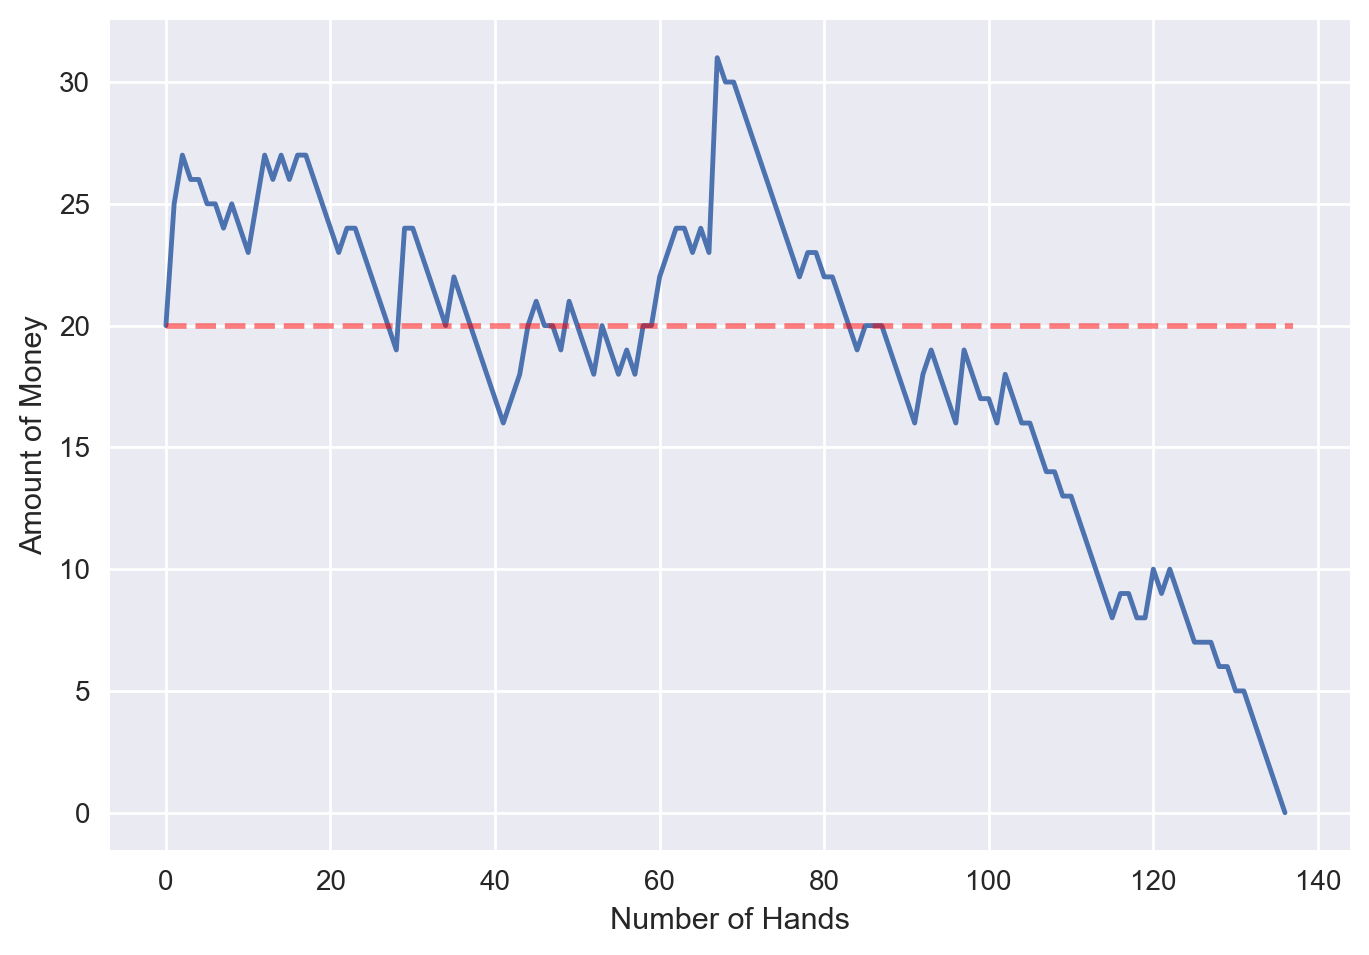

In [23]:
plt.figure(dpi=200)
max_len = len(money_tally)
plt.plot(range(max_len), money_tally);
plt.plot([0,max_len],[20,20],'r--', lw=2, alpha=0.5)
plt.xlabel("Number of Hands")
plt.ylabel("Amount of Money");

## Let's compare this to randomly choosing a combo to hold.

In [24]:
def play_poker_randomly(money, max_count=10000, return_count=False, verbose=False):
    money = 20
    money_tally = [money]
    count = 0
    while money > 0 and count < max_count:
        count += 1
        money -= 1 
        cards = deck()
        cards.shuffle()
        cards.deal_five()

        cards.draw_cards(ids_to_hold=np.random.choice(possible_hold_combos), shuffle_remaining=True)
        winnings = jacks_or_better_scorer(cards.final_hand).score
        money += winnings
        money_tally.append(money)
        if count%10 == 0 and verbose:
            print("Hand %i, Money: %i"%(count,money))
    if return_count:
        return count
    else:
        return money_tally

In [25]:
random_survive = []
for _ in range(100):
    random_survive.append(play_poker_randomly(20, max_count=100, return_count=True))

In [26]:
num_proc = multiprocessing.cpu_count()
print("Found {} processors".format(num_proc))
pool = Pool(processes=num_proc) 

smart_survive = []
for play_num in range(100):
    print("Player Num: ", play_num)
    smart_survive.append(play_poker(20, max_count=100, sim_strength=100, return_count=True, pool=pool))

Found 4 processors
Player Num:  0
Player Num:  1
Player Num:  2
Player Num:  3
Player Num:  4
Player Num:  5
Player Num:  6
Player Num:  7
Player Num:  8
Player Num:  9
Player Num:  10
Player Num:  11
Player Num:  12
Player Num:  13
Player Num:  14
Player Num:  15
Player Num:  16
Player Num:  17
Player Num:  18
Player Num:  19
Player Num:  20
Player Num:  21
Player Num:  22
Player Num:  23
Player Num:  24
Player Num:  25
Player Num:  26
Player Num:  27
Player Num:  28
Player Num:  29
Player Num:  30
Player Num:  31
Player Num:  32
Player Num:  33
Player Num:  34
Player Num:  35
Player Num:  36
Player Num:  37
Player Num:  38
Player Num:  39
Player Num:  40
Player Num:  41
Player Num:  42
Player Num:  43
Player Num:  44
Player Num:  45
Player Num:  46
Player Num:  47
Player Num:  48
Player Num:  49
Player Num:  50
Player Num:  51
Player Num:  52
Player Num:  53
Player Num:  54
Player Num:  55
Player Num:  56
Player Num:  57
Player Num:  58
Player Num:  59
Player Num:  60
Player Num:  61

Process ForkPoolWorker-15:
Process ForkPoolWorker-16:
Process ForkPoolWorker-13:
Process ForkPoolWorker-14:
Traceback (most recent call last):
  File "/Users/zachariahmiller/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/zachariahmiller/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/zachariahmiller/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
Traceback (most recent call last):
  File "/Users/zachariahmiller/anaconda3/lib/python3.6/multiprocessing/queues.py", line 342, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/zachariahmiller/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/zachariahmiller/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    se

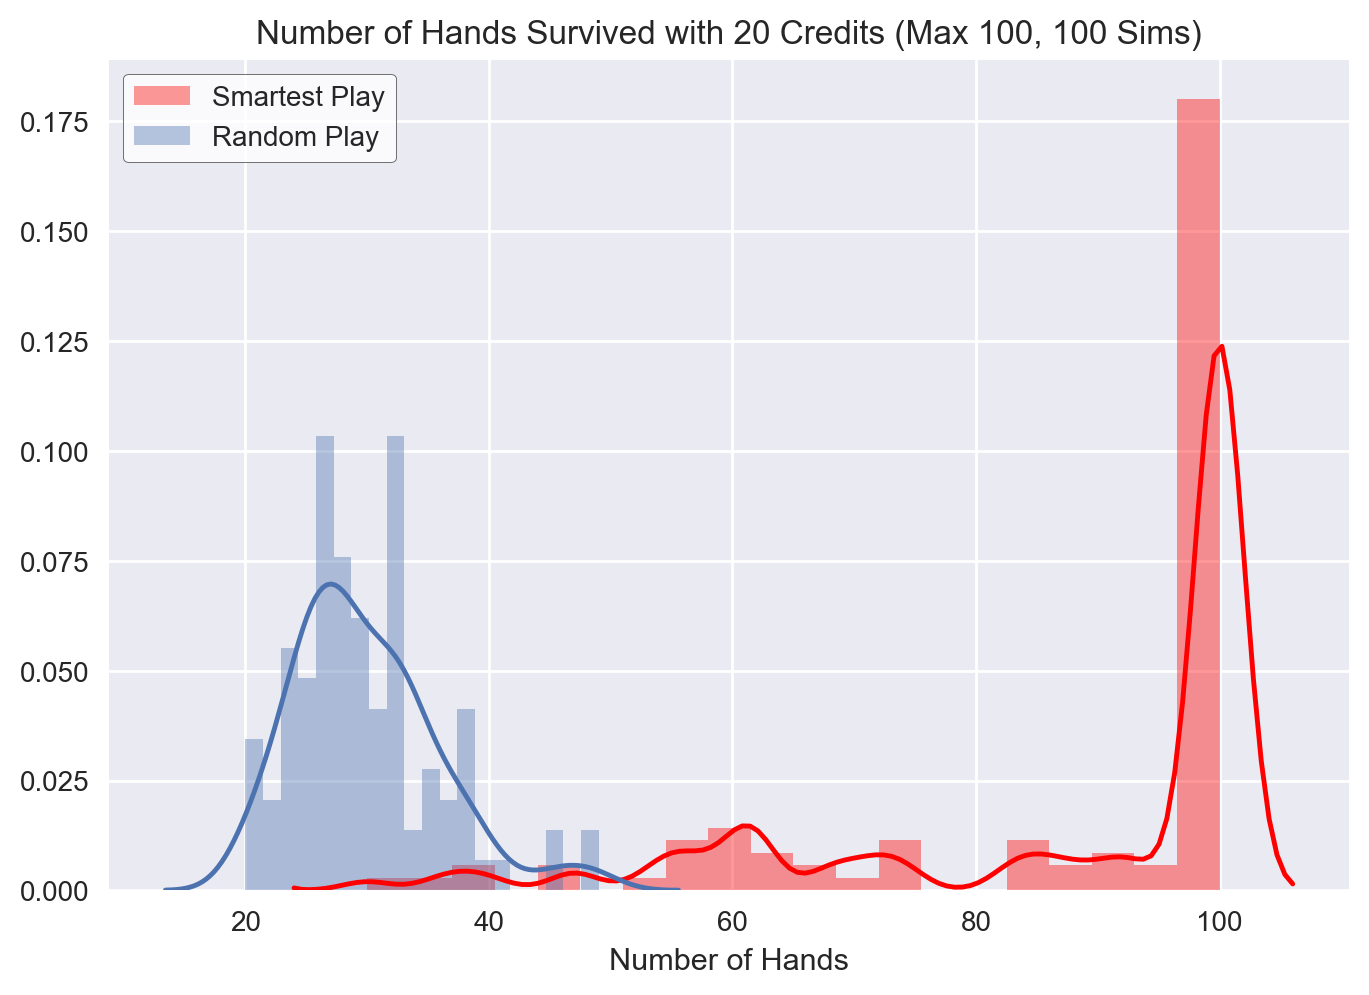

In [27]:
import seaborn as sns
plt.figure(dpi=200)
sns.distplot(smart_survive, color='r', label="Smartest Play", bins=20, kde_kws={"bw":2});
sns.distplot(random_survive, label="Random Play", bins=20);
plt.legend(loc='upper left', frameon=True, facecolor='#FFFFFF', edgecolor='#333333');
plt.title("Number of Hands Survived with 20 Credits (Max 100, 100 Sims)");
plt.xlabel("Number of Hands");

In [60]:
smart_survive_2 = []
for play_num in range(100):
    if play_num%10==0:
        print("Player Num: ", play_num)
    smart_survive_2.append(play_poker(20, max_count=500, sim_strength=100, first_sim_pass=15, return_count=True))

Player Num:  0
Player Num:  10
Player Num:  20
Player Num:  30
Player Num:  40
Player Num:  50
Player Num:  60
Player Num:  70
Player Num:  80
Player Num:  90


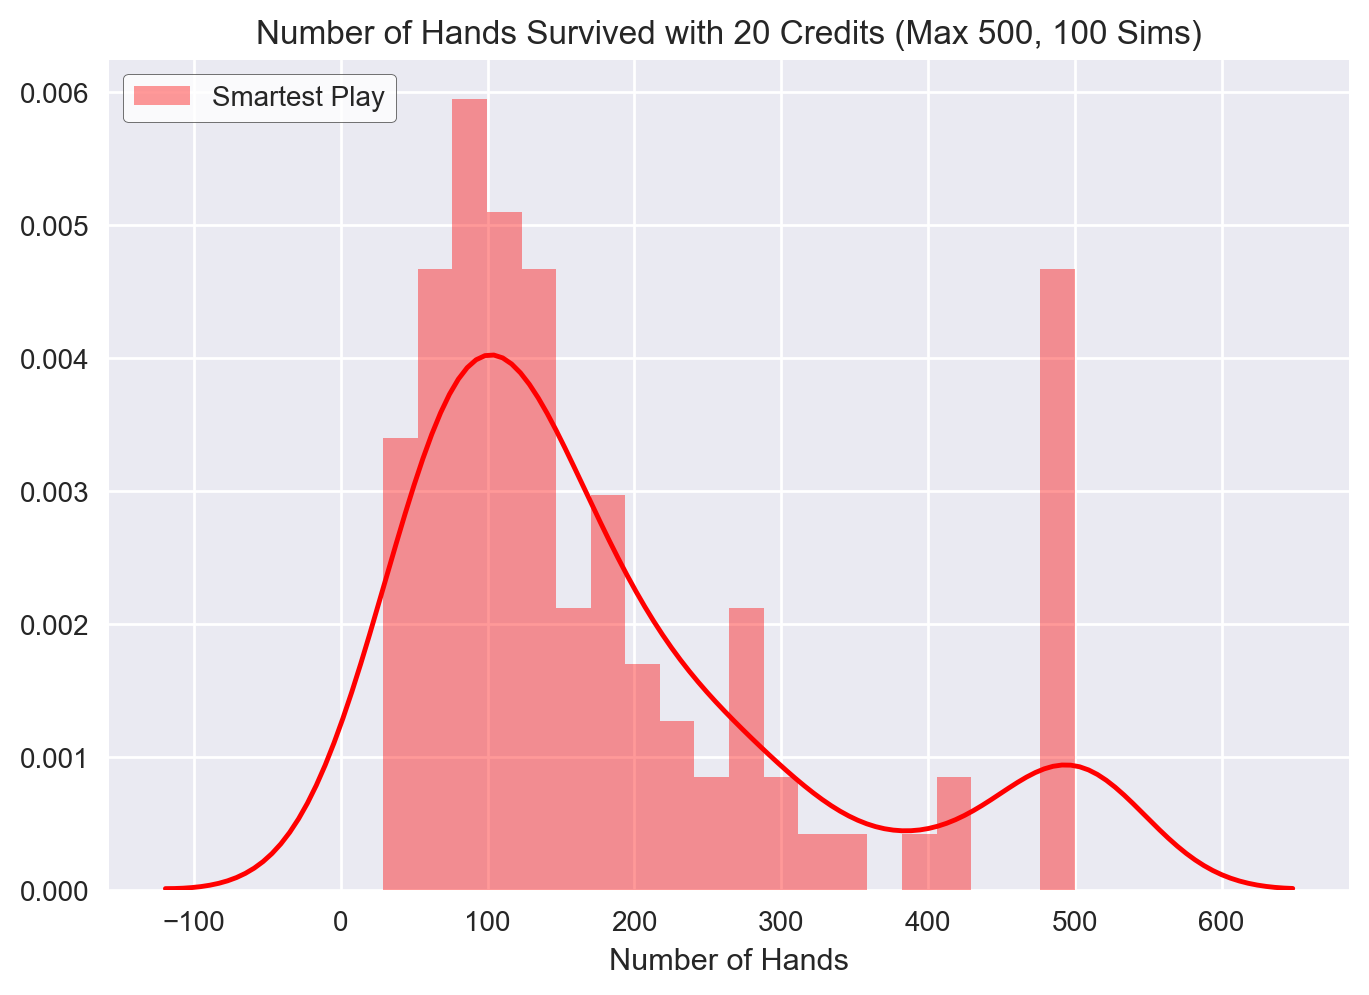

In [61]:
plt.figure(dpi=200)
sns.distplot(smart_survive_2, color='r', label="Smartest Play", bins=20);
plt.legend(loc='upper left', frameon=True, facecolor='#FFFFFF', edgecolor='#333333');
plt.title("Number of Hands Survived with 20 Credits (Max 500, 100 Sims)");
plt.xlabel("Number of Hands");

In [ ]:
smart_survive_3 = []
smart_tally_3 = []

In [33]:
num_proc = multiprocessing.cpu_count()
print("Found {} processors".format(num_proc))
pool = Pool(processes=num_proc) 
for player_num in range(500):
    print("Player ", player_num)
    i,j = play_poker(20, max_count=1000, sim_strength=100, return_both=True, pool=pool)
    smart_survive_3.append(i)
    smart_tally_3.append(j)

Found 4 processors
Player  0
Player  1
Player  2
Player  3
Player  4
Player  5
Player  6
Player  7
Player  8
Player  9
Player  10
Player  11
Player  12
Player  13
Player  14
Player  15
Player  16
Player  17
Player  18
Player  19
Player  20
Player  21
Player  22
Player  23
Player  24
Player  25
Player  26
Player  27
Player  28
Player  29
Player  30
Player  31
Player  32
Player  33
Player  34
Player  35
Player  36
Player  37
Player  38
Player  39
Player  40
Player  41
Player  42
Player  43
Player  44
Player  45
Player  46
Player  47
Player  48
Player  49
Player  50
Player  51
Player  52
Player  53
Player  54
Player  55
Player  56
Player  57
Player  58
Player  59
Player  60
Player  61
Player  62
Player  63
Player  64
Player  65
Player  66
Player  67
Player  68
Player  69
Player  70
Player  71
Player  72
Player  73
Player  74
Player  75
Player  76
Player  77
Player  78
Player  79
Player  80
Player  81
Player  82
Player  83
Player  84
Player  85
Player  86
Player  87
Player  88
Player  89
P

KeyboardInterrupt: 

Process ForkPoolWorker-70:
Process ForkPoolWorker-72:
Process ForkPoolWorker-69:
Traceback (most recent call last):
  File "/Users/zachariahmiller/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/zachariahmiller/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/Users/zachariahmiller/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/Users/zachariahmiller/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/zachariahmiller/anaconda3/lib/python3.6/multiprocessing/pool.py", line 47, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/Users/zachariahmiller/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ip

In [34]:
import pickle

pickle.dump(smart_tally_3, open('money_time_series_parallel_100sims.p','wb'))

In [37]:
random_survive3 = []
for _ in range(len(smart_survive_3)):
    random_survive3.append(play_poker_randomly(20, max_count=100, return_count=True))

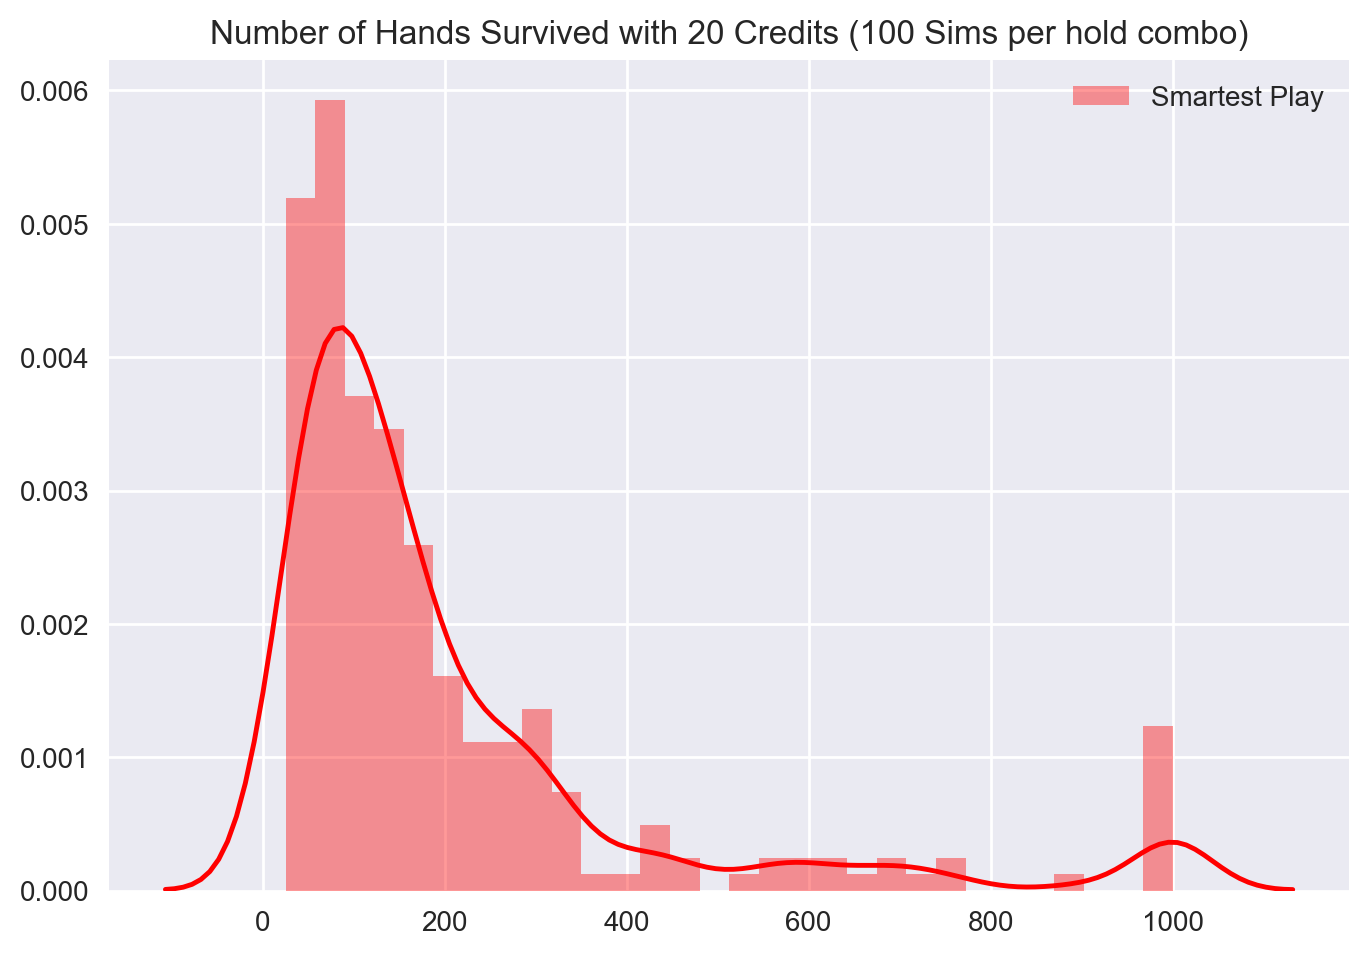

In [41]:
plt.figure(dpi=200)
sns.distplot(smart_survive_3, color='r', label="Smartest Play", bins=30);
plt.legend(loc='upper right');
plt.title("Number of Hands Survived with 20 Credits (100 Sims per hold combo)");

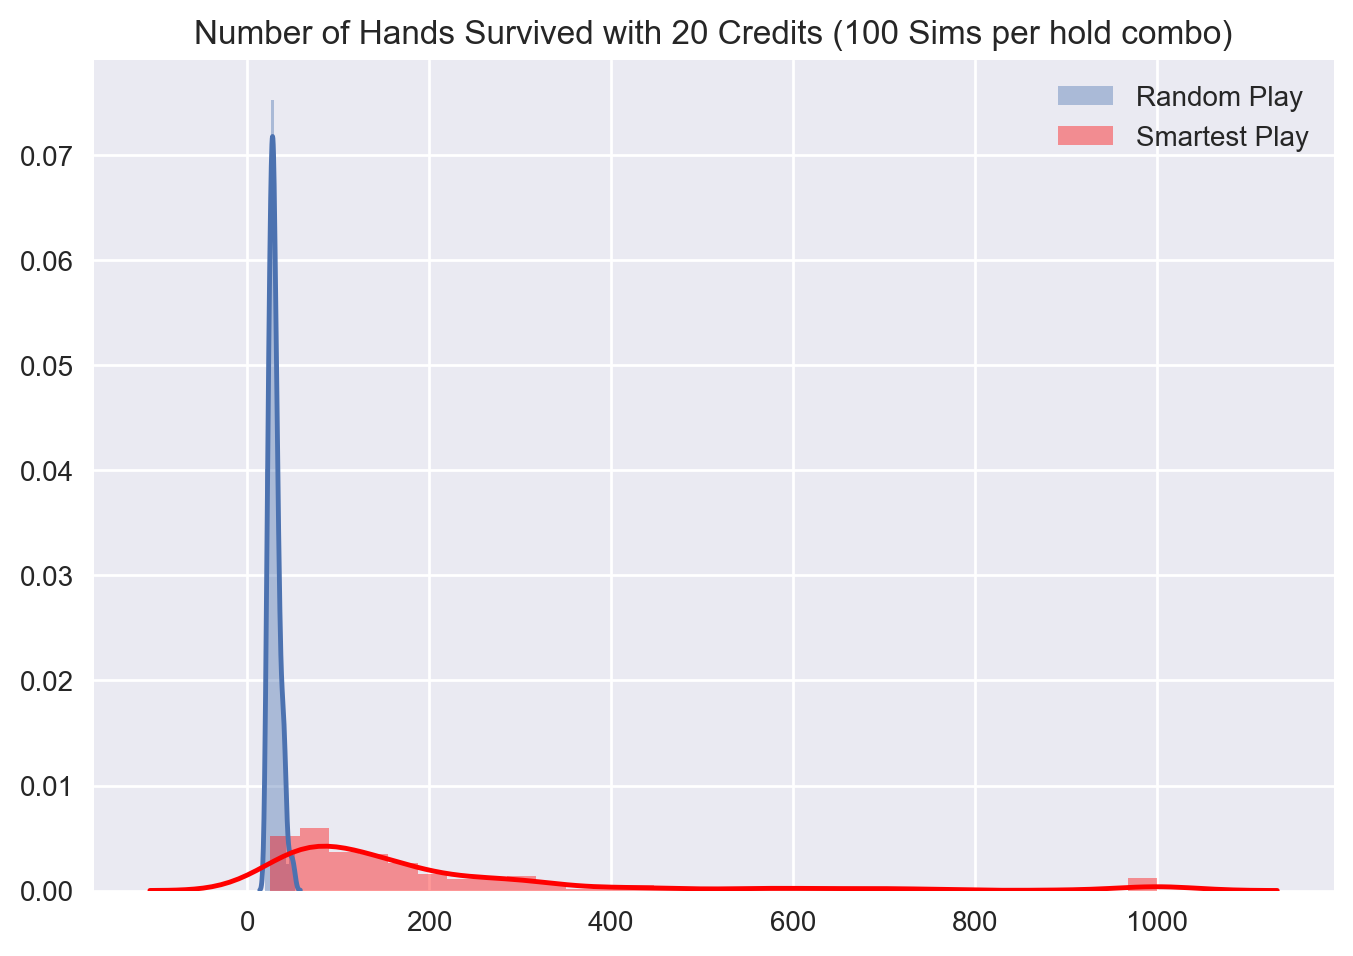

In [44]:
plt.figure(dpi=200)
sns.distplot(random_survive3, label="Random Play", bins=10);
sns.distplot(smart_survive_3, color='r', label="Smartest Play", bins=30);
plt.legend(loc='upper right');
plt.title("Number of Hands Survived with 20 Credits (100 Sims per hold combo)");

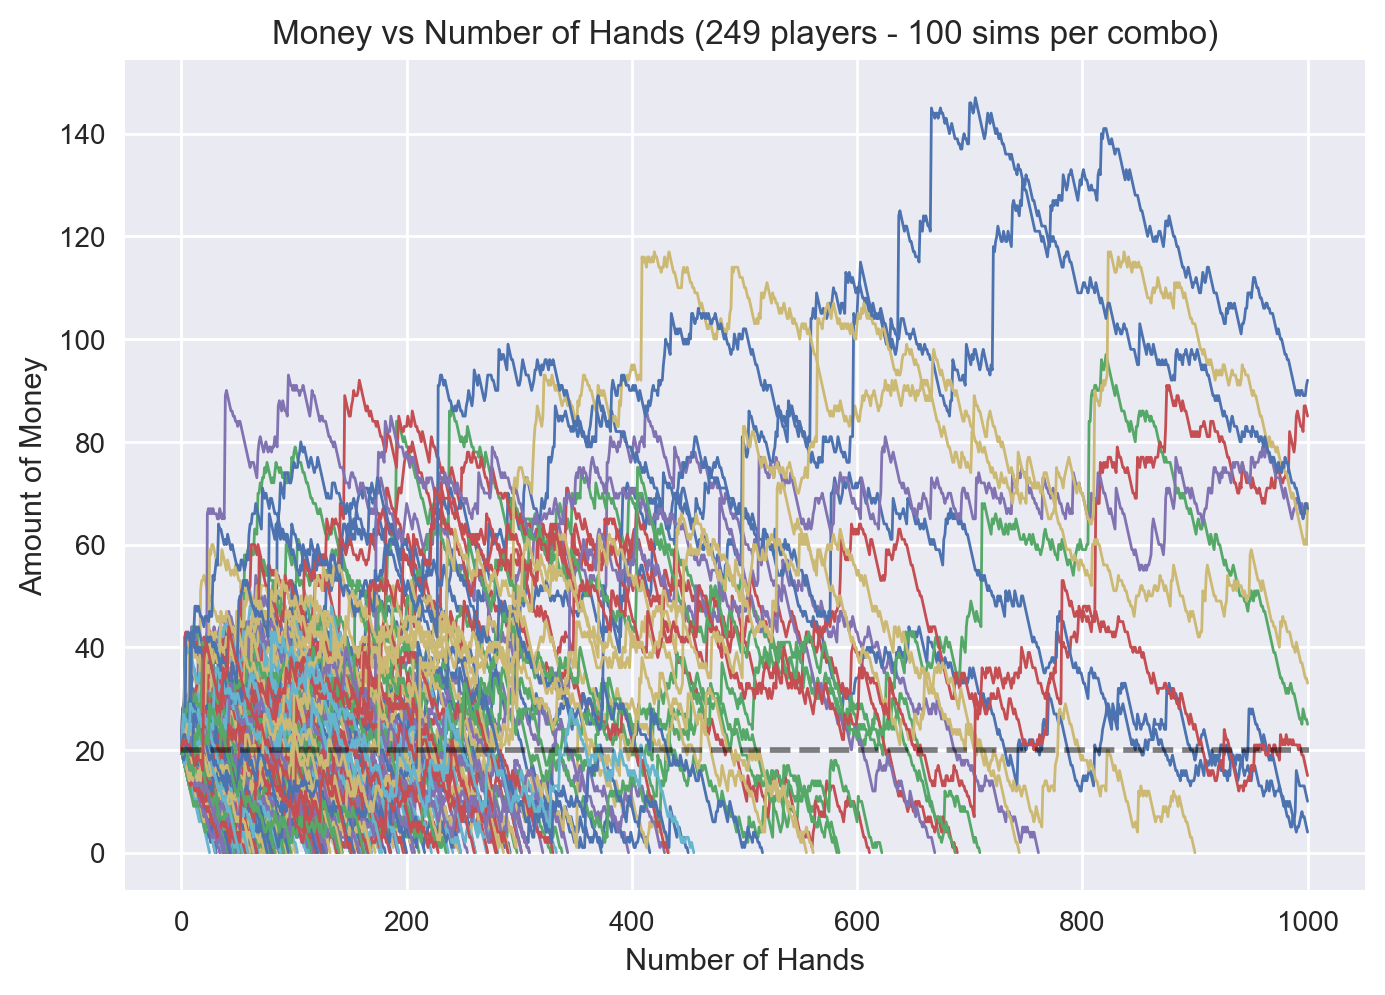

In [45]:
max_max_len = 0
plt.figure(dpi=200)
plt.xlabel("Number of Hands")
plt.ylabel("Amount of Money");
plt.title("Money vs Number of Hands ({} players - 100 sims per combo)".format(len(smart_tally_3)))
for money_tally in smart_tally_3:
    max_len = len(money_tally)
    if max_len > max_max_len:
        max_max_len = max_len
    plt.plot(range(max_len), money_tally, lw=1);
plt.plot([0,max_max_len],[20,20],'k--', lw=2, alpha=0.5);

In [46]:
total_survivors = 0
total_profitors = 0
for x in smart_tally_3:
    if len(x) == 1001:
        total_survivors += 1
        if x[-1] > 20:
            total_profitors += 1
            
print("Percent lasting 1000 hands: ", str(round(total_survivors/len(smart_tally_3),3)))
print("Percent with profit after 1000 hands: ", str(round(total_profitors/len(smart_tally_3),3)))

Percent lasting 1000 hands:  0.04
Percent with profit after 1000 hands:  0.028


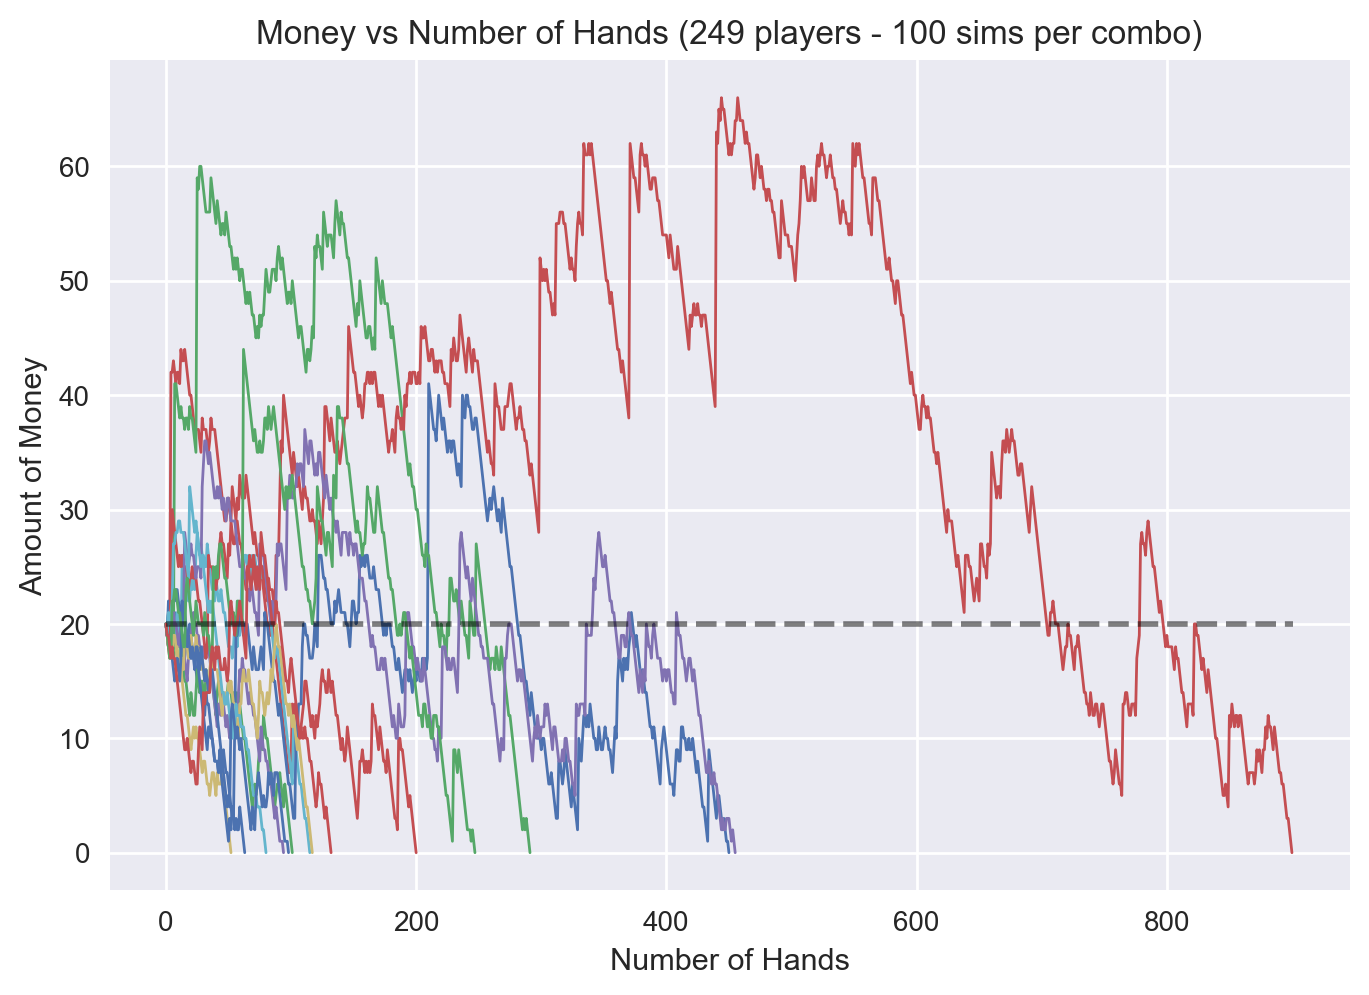

In [50]:
max_max_len = 0
plt.figure(dpi=200)
plt.xlabel("Number of Hands")
plt.ylabel("Amount of Money");
plt.title("Money vs Number of Hands ({} players - 100 sims per combo)".format(len(smart_tally_3)))
for money_tally in np.random.choice(smart_tally_3,15):
    max_len = len(money_tally)
    if max_len > max_max_len:
        max_max_len = max_len
    plt.plot(range(max_len), money_tally, lw=1);
plt.plot([0,max_max_len],[20,20],'k--', lw=2, alpha=0.5);